<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/piecewise_linear_pytorch_opt_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cpu'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
dtype = torch.float32

Using device: cpu


Define the original function f, the transform itself g, and the transformed function h.

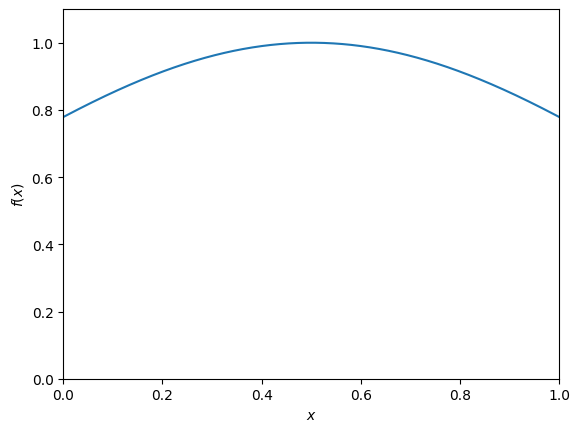

In [3]:
def f(x):
  return torch.exp(-(x-0.5)**2)

xs = torch.linspace(0, 1, 1000)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.show()

In [4]:
def g(x, params, bins):   #piecewise linear transform with K bins

  device = x.device
  dtype = x.dtype
  K = len(params) + 1


  #cdf heights
  heights = torch.cat([torch.tensor([0.0]), params, torch.tensor([1.0])])

  #find indices
  i_values = torch.bucketize(x, bins, right=False) - 1
  i_values_right = torch.clamp(i_values + 1, max=K)

  #find the correct bin indices i for each x value
  #i_values = torch.clamp((x * K).long(), max=K-1)

  #compute the edges
  x_left = bins[i_values]
  x_right = bins[i_values_right]
  y_left = heights[i_values]
  y_right = heights[i_values_right]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)


In [6]:
def plot_g(params, bins, display_bins):

  x_plot = torch.rand(1000)
  x_plot = x_plot.sort().values

  g_plot = g(x_plot, params, bins)

  fig, ax = plt.subplots()

  ax.plot(x_plot.cpu(), g_plot.cpu())

  if display_bins == True:
    for b in bins[1:-1]:
      ax.axvline(b.item(), color="gray", alpha=0.6)

  ax.set_xlabel(f"$x$", fontsize=14)
  ax.set_ylabel(f"$g(x)$", fontsize=14)

  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(0.0, 1.0)

  ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="in", length=3)
  ax.minorticks_on()

  plt.show()

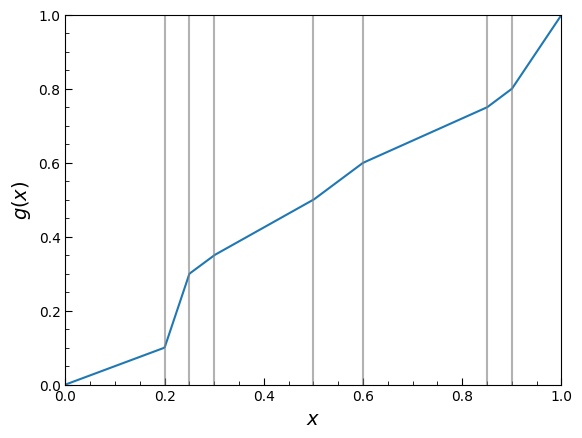

In [8]:
#test plot

test_params = torch.tensor([0.1, 0.3, 0.35, 0.5, 0.6, 0.75, 0.8])
test_bins = torch.tensor([0, 0.2, 0.25, 0.3, 0.5, 0.6, 0.85, 0.9, 1])

plot_g(test_params, test_bins, True)

In [9]:
def h(y, params, bins):
  '''
  Resulting function when the piecewise warp is applied, in accordance with the change of variables formula.
  Integral should be preserved.
  Non-uniform bins permitted.
  '''

  device = y.device
  dtype = y.dtype
  K = len(params) + 1

  #cdf heights
  heights = torch.cat([torch.tensor([0.0]), params, torch.tensor([1.0])])

  #find indices
  j_values = torch.bucketize(y, heights, right=False) - 1
  j_values_right = torch.clamp(j_values + 1, max=K)

  #find the correct indices
  #j_values = torch.clamp((torch.searchsorted(ys, y) - 1), 0, K-1)

  #compute the edges
  x_left = bins[j_values]
  x_right = bins[j_values+1]
  y_left = heights[j_values]
  y_right = heights[j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  jacobians = (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)

  return f(arg) * jacobians

In [12]:
#plot h

def plot_h(params, bins):

  y_plot = torch.rand(1000)
  y_plot = y_plot.sort().values

  h_plot = h(y_plot, params, bins)

  fig, ax = plt.subplots()

  ax.plot(y_plot.cpu(), h_plot.cpu())

  ax.set_xlabel(f"$y$", fontsize=14)
  ax.set_ylabel(f"$h(y)$", fontsize=14)

  ax.set_xlim(0.0, 1.0)

  ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
  ax.tick_params(axis="both", which="minor", direction="in", length=3)
  ax.minorticks_on()

  plt.show()

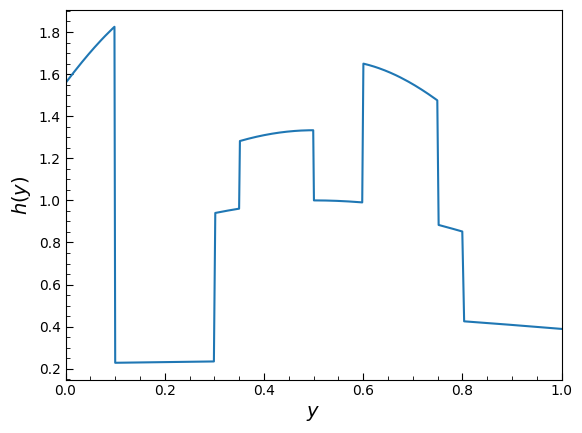

In [14]:
plot_h(test_params, test_bins)

Integral preservation and variance checks

In [17]:
N = 1000000

#reference value: 0.922562

def MC_F(N):
  x = torch.rand(N)
  f_evals = f(x)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params, bins):
  y = torch.rand(N)
  h_evals = h(y, params, bins)
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H


F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} ± {alpha_F}')

H_est, alpha_H = MC_H(N, test_params, test_bins)
print(f'H estimate = {H_est} ± {alpha_H}')


F estimate = 0.9225454330444336 ± 6.715362542308867e-05
H estimate = 0.9226524829864502 ± 0.0005458968225866556


In [23]:
#check variances are different in general

x_test, y_test = torch.rand(N), torch.rand(N)

f_var = torch.var(f(x_test))

h_for_var = h(y_test, test_params, test_bins)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0045)
H variance: tensor(0.2980)


Optimisation via training loop

In [28]:
#unconstrained parameters
import torch.nn.functional
def u_to_y(u):
  device = u.device
  dtype = u.dtype

  u_ext = torch.cat([u, torch.tensor([0.0])])
  w = torch.nn.functional.softmax(u_ext, dim=0)
  ys = torch.cumsum(w, dim=0)
  return ys[:-1]

def softmax(widths):
  return torch.nn.functional.softmax(widths, dim=0)

def widths_to_edges(widths):    #assumes widths sum to 1

  int_edges = torch.cumsum(widths, dim=0)
  edges = torch.cat([torch.tensor([0.0]), int_edges], dim=0)
  return edges


example_params = torch.zeros(7)
example_raw_widths = torch.rand(8)

widths = softmax(example_raw_widths)
print(widths)
edges = widths_to_edges(widths)
print(edges)

tensor([0.0969, 0.1524, 0.1023, 0.1735, 0.1653, 0.1599, 0.0694, 0.0803])
tensor([0.0000, 0.0969, 0.2493, 0.3516, 0.5251, 0.6904, 0.8503, 0.9197, 1.0000])


In [29]:
#optimisation

#can use a training loop, variance is the loss function

def train_loop_improved(x, K, epochs, lr, device, ticker):

  if device is None:
    device = x.device

  x = x.to(device=device, dtype=dtype)    #float64 precision can be added here

  #cdf heights
  raw_heights = torch.zeros((K-1), requires_grad=True, device=device, dtype=dtype)

  #bin widths
  raw_widths = torch.rand((K), requires_grad=True, device=device, dtype=dtype)

  #optimiser
  optimiser = torch.optim.Adam([
      {"params": raw_heights, "lr": lr},
      {"params": raw_widths, "lr": lr * 0.25}   #decoupled learning rates
      ])

  loss_values = torch.zeros(epochs)

  for epoch in range(epochs):

    heights = u_to_y(raw_heights)
    widths = softmax(raw_widths)
    bins = widths_to_edges(widths)

    g_eval = g(x, heights, bins)
    h_eval = h(g_eval, heights, bins)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss.detach()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if ticker and epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.8e}")

    final_loss = loss.detach()
    final_params = u_to_y(raw_heights).detach()
    final_widths = softmax(raw_widths).detach()

  return final_loss, loss_values, final_params, final_widths

In [40]:
train_x = torch.rand(1000)
final_loss, loss_values, opt_params, opt_widths = train_loop_improved(train_x, K=32, epochs=250, lr=0.05, device=device, ticker=True)

opt_bins = widths_to_edges(opt_widths)

print("Final loss:", final_loss.item())
print("Optimised parameters:", opt_params)
print("Optimised bin edges:", opt_bins)

Epoch: 0 | Loss: 8.70408341e-02
Epoch: 10 | Loss: 8.45502596e-03
Epoch: 20 | Loss: 3.07368767e-03
Epoch: 30 | Loss: 1.07446825e-03
Epoch: 40 | Loss: 2.90326745e-04
Epoch: 50 | Loss: 1.76134141e-04
Epoch: 60 | Loss: 7.49045066e-05
Epoch: 70 | Loss: 4.28304083e-05
Epoch: 80 | Loss: 2.90181833e-05
Epoch: 90 | Loss: 2.62983249e-05
Epoch: 100 | Loss: 2.53000744e-05
Epoch: 110 | Loss: 2.45718529e-05
Epoch: 120 | Loss: 2.43389550e-05
Epoch: 130 | Loss: 2.42398346e-05
Epoch: 140 | Loss: 2.42005553e-05
Epoch: 150 | Loss: 2.41901707e-05
Epoch: 160 | Loss: 2.41864673e-05
Epoch: 170 | Loss: 2.41849993e-05
Epoch: 180 | Loss: 2.41846155e-05
Epoch: 190 | Loss: 2.41878115e-05
Epoch: 200 | Loss: 2.41878315e-05
Epoch: 210 | Loss: 2.41877133e-05
Epoch: 220 | Loss: 2.41876933e-05
Epoch: 230 | Loss: 2.41876405e-05
Epoch: 240 | Loss: 2.41876205e-05
Final loss: 2.4187611415982246e-05
Optimised parameters: tensor([0.0230, 0.0491, 0.0876, 0.1273, 0.1509, 0.1844, 0.2195, 0.2426, 0.2673,
        0.3102, 0.3333, 

Plots of g and h after optimisation

Optimised parameters: tensor([0.0230, 0.0491, 0.0876, 0.1273, 0.1509, 0.1844, 0.2195, 0.2426, 0.2673,
        0.3102, 0.3333, 0.3639, 0.3881, 0.4338, 0.4674, 0.5123, 0.5371, 0.5792,
        0.6169, 0.6411, 0.6729, 0.7171, 0.7556, 0.7800, 0.8067, 0.8294, 0.8604,
        0.8849, 0.9188, 0.9434, 0.9685])
Optimised bin edges: tensor([0.0000, 0.0268, 0.0566, 0.0990, 0.1413, 0.1658, 0.2001, 0.2352, 0.2579,
        0.2820, 0.3231, 0.3451, 0.3738, 0.3965, 0.4389, 0.4700, 0.5114, 0.5344,
        0.5732, 0.6084, 0.6310, 0.6609, 0.7031, 0.7404, 0.7644, 0.7910, 0.8139,
        0.8459, 0.8716, 0.9080, 0.9351, 0.9633, 1.0000])


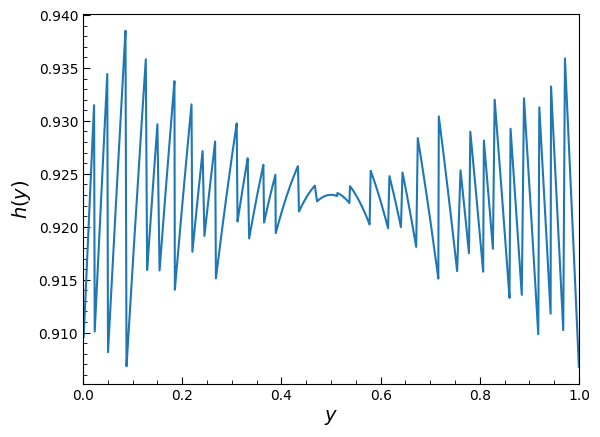

In [41]:
print("Optimised parameters:", opt_params)
print("Optimised bin edges:", opt_bins)

plot_h(opt_params, opt_bins)

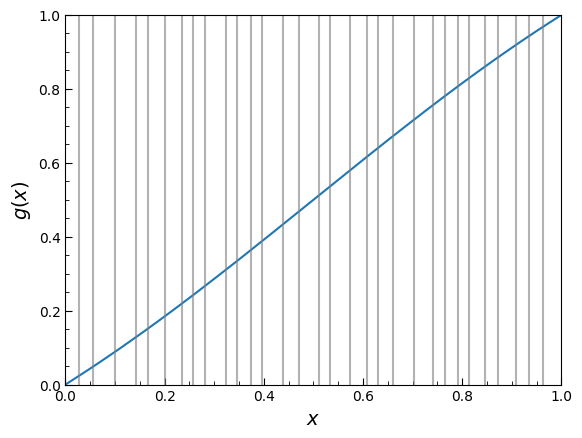

In [42]:
plot_g(opt_params, opt_bins, display_bins=True)

Analysis section

Loss vs epoch for different values of K

In [43]:
#generate data

device = x_test.device
dtype = x_test.dtype

K_s = [2, 4, 8, 16, 32, 64, 128]
epochs = 200
loss_values = torch.zeros((len(K_s), epochs), device=device, dtype=dtype)

results = {}  # K -> loss tensor

for K in K_s:
    _, losses, _, _ = train_loop_improved(
        train_x,
        K,
        epochs,
        lr=0.05,
        device=device,
        ticker=False,
    )
    results[K] = losses.detach().cpu()

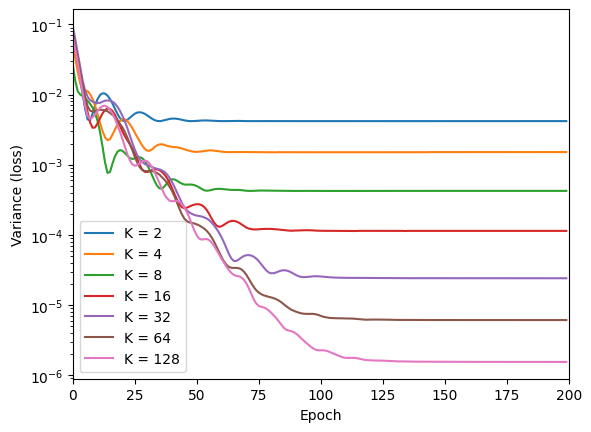

In [45]:
#plotting for early stopping-friendly method for future

plt.figure()

for K, losses in results.items():
  epochs_plot = torch.arange(len(losses))
  plt.plot(epochs_plot, losses.numpy(), label=f"K = {K}")

plt.xlabel("Epoch")
plt.ylabel("Variance (loss)")
plt.yscale("log")
plt.xlim(0, 200)
plt.legend()
plt.show()

Final loss vs K

In [46]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks), device=device)
i=0

for K in Ks:
  result = train_loop_improved(train_x, K, 200, lr=0.05, device=device, ticker=False)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

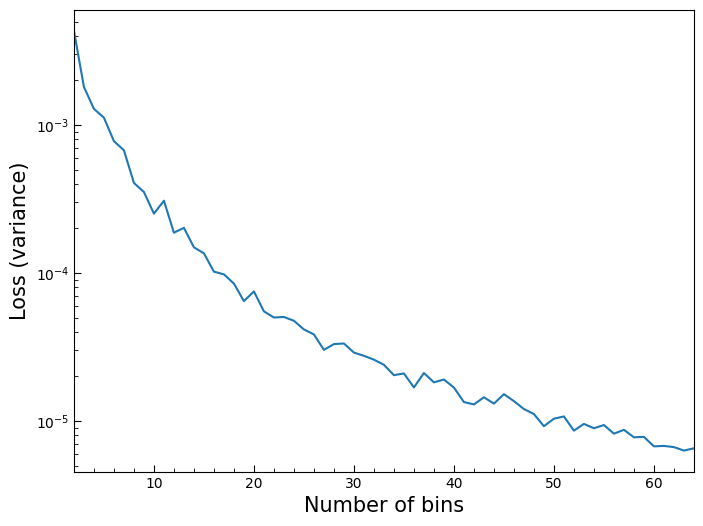

tensor(6.5425e-06)


In [47]:
#plotting

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ks, vars.detach().numpy())  # Detach and convert to numpy for plotting

ax.set_xlabel("Number of bins", fontsize=15)
ax.set_ylabel("Loss (variance)", fontsize=15)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(2, 64)
plt.yscale('log')
plt.show()
print(vars[-1])     #check accuracy

Loss vs epoch for different learning rates

In [48]:
#generate data
x = torch.rand(1000)
K = 16
l_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
epochs=200
loss_values = torch.zeros((len(l_rates), epochs))

for i in range(len(l_rates)):
  loss_values[i] = train_loop_improved(x, K, epochs, lr=l_rates[i], device=device, ticker=False)[1]

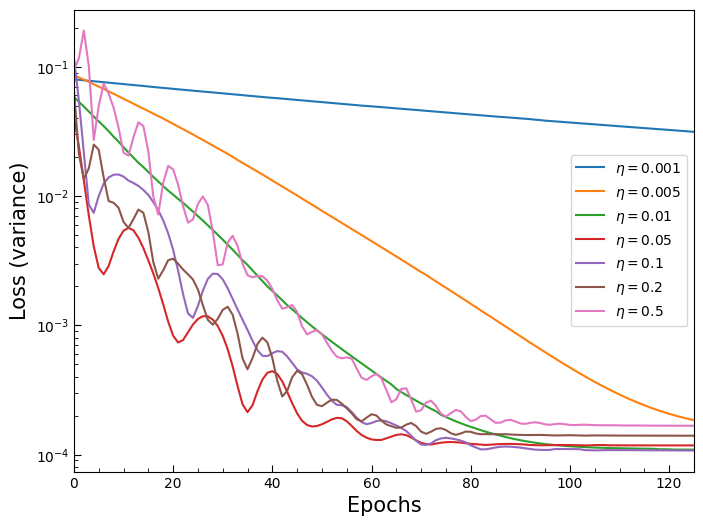

In [50]:
#plotting

fig, ax = plt.subplots(figsize=(8, 6))

epochs_plot = torch.arange(epochs, device='cpu')
for i in range(len(l_rates)):
  ax.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=rf"$\eta = {l_rates[i]}$")

ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel("Loss (variance)", fontsize=15)

ax.tick_params(axis="both", which="major", direction="in", length=5, labelsize=10)
ax.tick_params(axis="both", which="minor", direction="in", length=3)
ax.minorticks_on()

ax.set_xlim(0, 125)

plt.legend()
plt.yscale('log')
plt.show()

Code below purely for saving finished functions to a Python script and will not necessarily match the above yet

In [ ]:
#saving functions to drive

!mkdir -p /content/drive/MyDrive/nf_code

In [ ]:
%%writefile /content/drive/MyDrive/nf_code/pwlinear.py

import torch

def g_1d_linear(x, y_params):   #piecewise linear transform with K bins

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = torch.linspace(0, 1, K+1)
  ys = torch.cat([torch.tensor([0.0]), y_params, torch.tensor([1.0])])

  #find the correct bin indices i for each x value
  i_values = torch.clamp((x * K).long(), max=K-1)

  #compute the edges
  x_left = x_bins[i_values]
  x_right = x_bins[i_values+1]
  y_left = ys[i_values]
  y_right = ys[i_values+1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)


def h_1d_linear(y, y_params, f):

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = torch.linspace(0, 1, K+1)
  ys = torch.cat([torch.tensor([0.0]), y_params, torch.tensor([1.0])])

  #find the correct indices
  j_values = torch.clamp((torch.searchsorted(ys, y) - 1), 0, K-1)

  #compute the edges
  x_left = x_bins[j_values]
  x_right = x_bins[j_values+1]
  y_left = ys[j_values]
  y_right = ys[j_values+1]

  def g_inv(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv(y)
  jac = jacobians(x_left, x_right, y_left, y_right)

  return f(arg) * jac


def u_to_y(u):
  u_ext = torch.cat([u, torch.tensor([0.0])])
  w = torch.nn.functional.softmax(u_ext, dim=0)
  ys = torch.cumsum(w, dim=0)
  return ys[:-1]


def train_loop_1dl(x, K, epochs, lr):

  u_params = torch.zeros(K-1, requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=lr)
  loss_values = torch.zeros(epochs)

  for epoch in range(epochs):
    y_params = u_to_y(u_params)
    y = g_1d_linear(x, y_params)
    h_eval = h_1d_linear(y, y_params)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return loss, loss_values

Overwriting /content/drive/MyDrive/nf_code/pwlinear.py


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/nf_code')


'/content/drive/MyDrive/nf_code' in sys.path

True

In [ ]:
sys.path.append('/content/drive/MyDrive')
import nf_code

from nf_code import pwlinear

In [ ]:
import torch
from torch import nn

x = torch.linspace(0, 1, 1000)
params = torch.rand(8)

pwlinear.u_to_y(params)

tensor([0.0772, 0.2667, 0.3475, 0.4306, 0.5124, 0.6549, 0.8051, 0.9252])

In [ ]:
%%writefile /content/drive/MyDrive/nf_code/__init__.py
# nf_code package


Writing /content/drive/MyDrive/nf_code/__init__.py
